In [1]:
import sys
import os
import json
import regex as re
from tqdm import tqdm

In [2]:
data = []
with open('mbpp_experimental_800.json', 'r', encoding='utf-8') as f:
    for point in json.load(f):
        instruction = re.split("(?:\n|\r\n)", point['instruction'])[0].strip()
        if instruction.lower().endswith("your code should pass these tests:"):
            instruction = instruction[:-len("your code should pass these tests:")].strip()
            data.append({
                'id': point['id'],
                'instruction': instruction
            })

In [3]:
len(data)

724

In [4]:
non_duplicated = 0
total = 0
y = []
x = []
l = []

In [5]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=False)

all_instructions = [
    "Write a function to find the minimum cost path to reach (m, n) from (0, 0) for the given cost matrix cost[][] and a position (m, n) in cost[][].",
    "Write a function to find the similar elements from the given two tuple lists.",
    "Write a python function to identify non-prime numbers.",
    "Write a function to find the largest integers from a given list of numbers using heap queue algorithm.",
    "Write a function to find the number of ways to fill it with 2 x 1 dominoes for the given 3 x n board.",
    "Write a python function to check whether the two numbers differ at one bit position only or not.",
    "Write a function to find all words which are at least 4 characters long in a string by using regex.",
    "Write a function to find squares of individual elements in a list using lambda function.",
    "Write a python function to find the minimum number of rotations required to get the same string.",
    "Write a function to get the n smallest items from a dataset."
]
all_instruction_tokens = [scorer._tokenizer.tokenize(inst) for inst in all_instructions]

In [6]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor
import numpy as np

discarded = []
with ProcessPoolExecutor() as executor:
    for point in tqdm(data):
        instruction = point['instruction']
        new_instruction_tokens = scorer._tokenizer.tokenize(instruction)
        rouge_scores = []
        for score in executor.map(
            partial(rouge_scorer._score_lcs, new_instruction_tokens),
            all_instruction_tokens
        ):
            rouge_scores.append(score.fmeasure)
        if max(rouge_scores) < float(2 / 3):
            non_duplicated += 1
            all_instructions.append(instruction)
            all_instruction_tokens.append(new_instruction_tokens)
        else:
            most_similar_instructions = {
                all_instructions[i]: rouge_scores[i] for i in np.argsort(rouge_scores)[-5:][::-1]
            }
            discarded.append({
                'discarded_instruction': instruction,
                'most_similar_instructions': most_similar_instructions
            })
        total += 1
        y.append(non_duplicated)
        x.append(total)
        l.append(len(instruction))

100%|██████████| 724/724 [00:42<00:00, 17.02it/s]


In [7]:
print(total, non_duplicated)

724 406


Text(0, 0.5, 'non-duplicated')

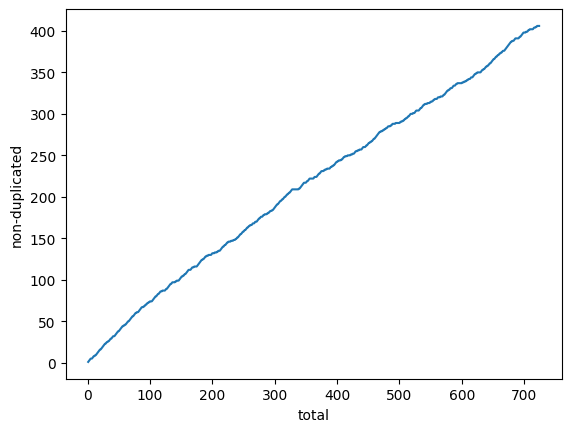

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

p = sns.lineplot(x=x, y=y)
p.set_xlabel('total')
p.set_ylabel('non-duplicated')